<a href="https://colab.research.google.com/github/mindjobs/Ecerlab/blob/main/Lab3%20v.1.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [13]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
from statsmodels.tsa.arima.model import ARIMA
from sklearn.metrics import mean_absolute_error

#ruta = "/content/cruce_diagnosticos.csv"
ruta = "/content/DATASET_LAB_3_FINAL.csv"
# Cargar el dataset
df = pd.read_csv(ruta)
#df.head()
display(df.head())
df.info()


warnings.filterwarnings('ignore')

# Configuración para gráficos
plt.style.use('seaborn-v0_8')
plt.rcParams['figure.figsize'] = (12, 6)
plt.rcParams['font.size'] = 10

# Fecha más antigua
fecha_min = df["fecha_transaccion"].min()

# Fecha más reciente
fecha_max = df["fecha_transaccion"].max()

print("Fecha más antigua:", fecha_min)
print("Fecha más reciente:", fecha_max)



,fecha_transaccion,anio,mes,anio_mes,anio_semana_iso,unidades
0,2021-01-02,2021,1,202101,202053,70
1,2021-01-03,2021,1,202101,202053,66
2,2021-01-04,2021,1,202101,202101,545
3,2021-01-05,2021,1,202101,202101,523
4,2021-01-06,2021,1,202101,202101,562


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1660 entries, 0 to 1659
Data columns (total 6 columns):
 #   Column             Non-Null Count  Dtype 
---  ------             --------------  ----- 
 0   fecha_transaccion  1660 non-null   object
 1   anio               1660 non-null   int64 
 2   mes                1660 non-null   int64 
 3   anio_mes           1660 non-null   int64 
 4   anio_semana_iso    1660 non-null   int64 
 5   unidades           1660 non-null   int64 
dtypes: int64(5), object(1)
memory usage: 77.9+ KB
Fecha más antigua: 2021-01-02
Fecha más reciente: 2025-09-06


Paso 1: "Exploración Inicial de la Data"

Procedemos a cargar el dataset en df el cual contiene 1660 filas y 6 columnas. Luego inspeccionamos la estructura con df.info()
No se identifican nulos por columna (todos 1660).
Luego identificamos los tipos: 5 columnas int64 (anio, mes, anio_mes, anio_semana_iso, unidades) y 1 object (fecha_transaccion).

Finalmente calculamos el rango temporal el cual se sitúa entre:
Fecha más antigua: 2021-01-02
Fecha más reciente: 2025-09-06

CAdvertimos que, como fecha_transaccion es object (string), pero para análisis de series (ADF, ARIMA, etc.) conviene convertirla a datetime, lo cual se realizará a continuación.

In [14]:
import numpy as np
import pandas as pd

# Limpieza y preparación
# Asegura tipo datetime y ordena por fecha
df["fecha_transaccion"] = pd.to_datetime(df["fecha_transaccion"], errors="coerce")
df = df.dropna(subset=["fecha_transaccion"]).sort_values("fecha_transaccion").reset_index(drop=True)

# Fechas extrema (inicio/fin de la serie)
fecha_min = df["fecha_transaccion"].min()
fecha_max = df["fecha_transaccion"].max()

#  Generamos columnas derivadas (sin pisar las que ya existen)
# Día y mes calculados desde la fecha
df["dia_semana"] = df["fecha_transaccion"].dt.day_name()           # Lunes, Martes, etc.
df["mes_nombre"] = df["fecha_transaccion"].dt.month_name()
df["anio_calc"] = df["fecha_transaccion"].dt.year
df["mes_calc"]  = df["fecha_transaccion"].dt.month
df["semana_iso_calc"] = df["fecha_transaccion"].dt.isocalendar().week.astype(int)
df["anio_iso_calc"]   = df["fecha_transaccion"].dt.isocalendar().year.astype(int)


#  Estadísticas rápidas
resumen_ventas = {
    "fecha_min": fecha_min,
    "fecha_max": fecha_max,
    "dias_totales": (fecha_max - fecha_min).days,
    "transacciones": int(df.shape[0]),
    "unidades_totales": int(df["unidades"].sum()),
    "unidades_promedio": float(df["unidades"].mean()),
    "unidades_min": int(df["unidades"].min()),
    "unidades_max": int(df["unidades"].max()),
}

#
# Mensual (por año-mes)
# Si ya existe 'anio_mes' numérico tipo 202401, se puede usar; aquí calculamos también un año-mes fecha para ordenar:
df["anio_mes_fecha"] = df["fecha_transaccion"].values.astype("datetime64[M]")
ventas_mensuales = (
    df.groupby(["anio_mes", "anio_mes_fecha"], as_index=False)["unidades"]
      .sum()
      .sort_values("anio_mes_fecha")
)

#  Semanal_iso (por año ISO y semana ISO)
ventas_semanales_iso = (
    df.groupby(["anio_iso_calc", "semana_iso_calc"], as_index=False)["unidades"]
      .sum()
      .sort_values(["anio_iso_calc", "semana_iso_calc"])
      .rename(columns={"anio_iso_calc": "anio_iso", "semana_iso_calc": "semana_iso"})
)

# Por día de semana (ordenado de Lunes a Domingo)
orden_dias = ["Monday","Tuesday","Wednesday","Thursday","Friday","Saturday","Sunday"]
df["dia_semana"] = pd.Categorical(df["dia_semana"], categories=orden_dias, ordered=True)
ventas_por_dia_semana = (
    df.groupby("dia_semana", as_index=False)["unidades"]
      .sum()
      .sort_values("dia_semana")
)

#  Ejemplos de salida por consola
print("\n== Resumen general ==")
for k, v in resumen_ventas.items():
    print(f"{k}: {v}")

print("\n== Ventas mensuales (primeras filas) ==")
print(ventas_mensuales.head())

print("\n== Ventas semanales ISO (primeras filas) ==")
print(ventas_semanales_iso.head())

print("\Ventas por día de semana ")
print(ventas_por_dia_semana)

# Top N períodos
# Top 5 meses y semanas con más unidades
top5_meses   = ventas_mensuales.sort_values("unidades", ascending=False).head(5)
top5_semanas = ventas_semanales_iso.sort_values("unidades", ascending=False).head(5)

print("\n== Top 5 meses por unidades ==")
print(top5_meses)
print("\n== Top 5 semanas ISO por unidades ==")
print(top5_semanas)



== Resumen general ==
fecha_min: 2021-01-02 00:00:00
fecha_max: 2025-09-06 00:00:00
dias_totales: 1708
transacciones: 1660
unidades_totales: 715663
unidades_promedio: 431.1222891566265
unidades_min: -1
unidades_max: 2339

== Ventas mensuales (primeras filas) ==
   anio_mes anio_mes_fecha  unidades
0    202101     2021-01-01      8543
1    202102     2021-02-01     11938
2    202103     2021-03-01      6619
3    202104     2021-04-01       662
4    202105     2021-05-01      7235

== Ventas semanales ISO (primeras filas) ==
   anio_iso  semana_iso  unidades
0      2020          53       136
1      2021           1      2794
2      2021           2      2259
3      2021           3      1676
4      2021           4      1678
\Ventas por día de semana 
  dia_semana  unidades
0     Monday     82792
1    Tuesday     82089
2  Wednesday     84760
3   Thursday     91858
4     Friday    115874
5   Saturday    154079
6     Sunday    104211

== Top 5 meses por unidades ==
    anio_mes anio_mes_f

Paso 2: "Limpieza, transformación y orden de la data"

Se convierte fecha_transaccion a datetime, elimina nulos en esa columna, ordena por fecha y resetea el índice.
Luego generamos las columnas derivadas de fechas (sin pisar las originales)
Generamos estadísticas rápidas para luego comenzar con las agregaciones que nos permitirá hacer los zoom necesarios.

- Mensual: se crea anio_mes_fecha (mes redondeado) y agrupa por anio_mes (ej. 202401) y anio_mes_fecha para sumar unidades, luego se ordena cronológicamente.

- Semanal ISO: agrupa por anio_iso_calc + semana_iso_calc y suma unidades; se renombra a anio_iso y semana_iso y ordena.

- Día de semana: se fuerza el orden Monday→Sunday con un Categorical, agrupa y ordena para ver qué días venden más en total.

✅ Índice temporal establecido y ordenado.


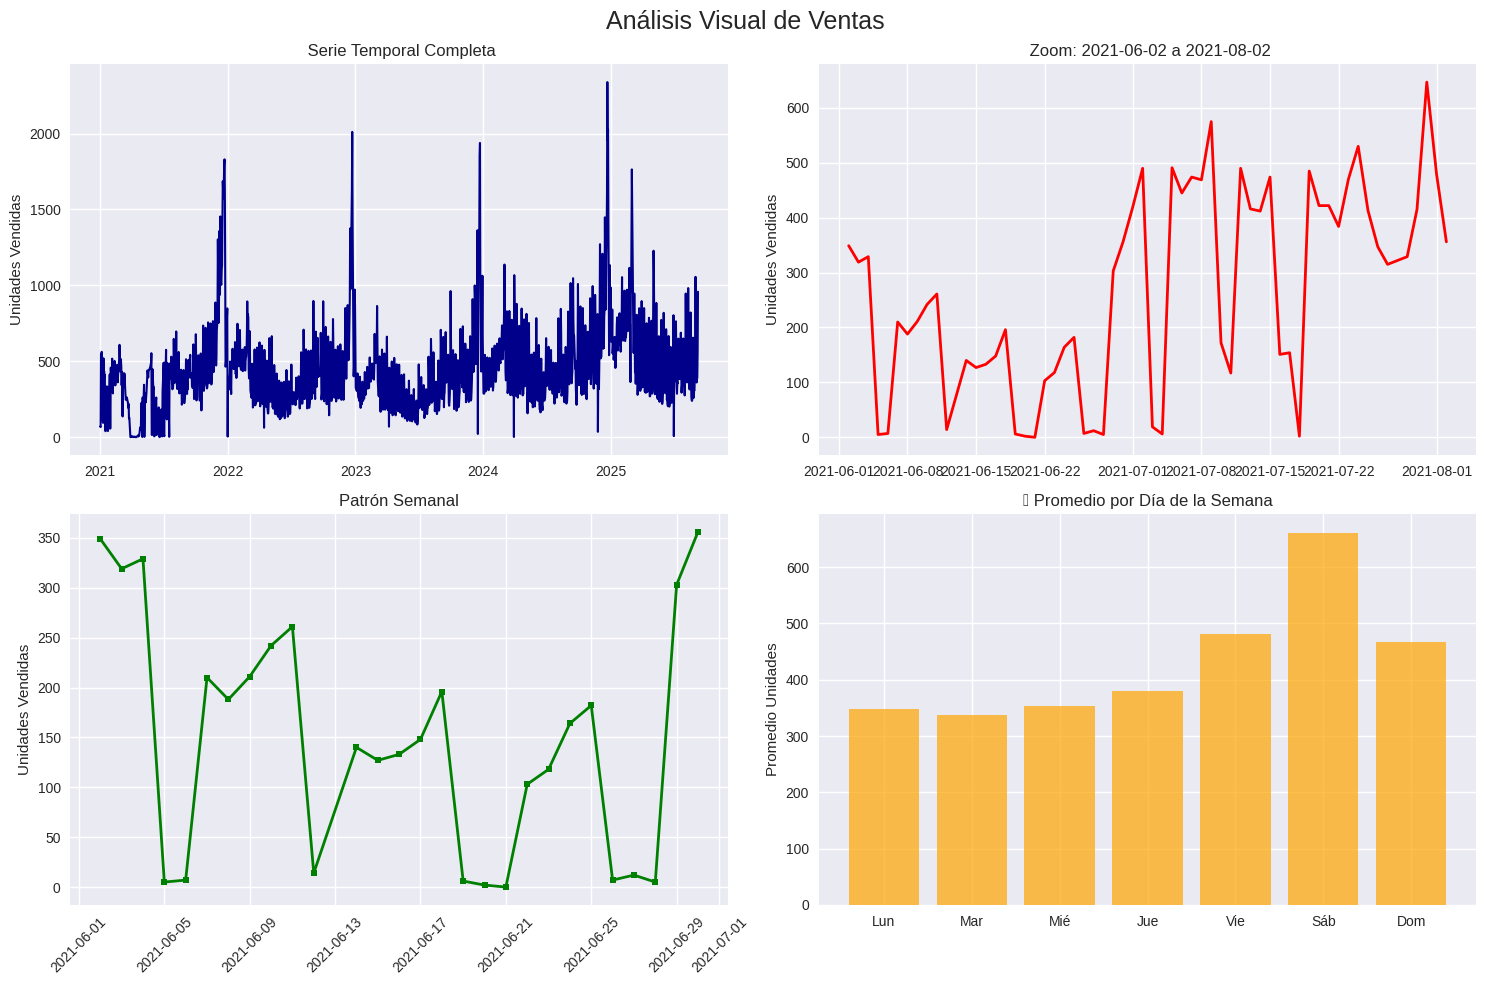

In [15]:
import matplotlib.pyplot as plt

# Establecemos la fecha como índice
df_ts = df.set_index('fecha_transaccion').sort_index()
print("✅ Índice temporal establecido y ordenado.")

# Gráficos
fig, axes = plt.subplots(2, 2, figsize=(15, 10))
fig.suptitle('Análisis Visual de Ventas', fontsize=18)

#Gráfico 1: Serie completa
axes[0,0].plot(df_ts['unidades'], linewidth=1.5, color='darkblue')
axes[0,0].set_title(' Serie Temporal Completa')
axes[0,0].set_ylabel('Unidades Vendidas')

# Gráfico 2: Zoom en un período específico (ejemplo: 3 meses del primer año)
fecha_inicio = df_ts.index.min() + pd.DateOffset(months=5)
fecha_fin    = fecha_inicio + pd.DateOffset(months=2)
zoom_periodo = df_ts.loc[fecha_inicio:fecha_fin]

axes[0,1].plot(zoom_periodo['unidades'], linewidth=2, color='red')
axes[0,1].set_title(f' Zoom: {fecha_inicio.date()} a {fecha_fin.date()}')
axes[0,1].set_ylabel('Unidades Vendidas')

# Gráfico 3: Patrón semanal (ejemplo: 4 semanas a partir de fecha_inicio)
cuatro_semanas = df_ts.loc[fecha_inicio: fecha_inicio + pd.DateOffset(weeks=4)]
axes[1,0].plot(
    cuatro_semanas.index,
    cuatro_semanas['unidades'],
    linewidth=2, color='green', marker='s', markersize=4
)
axes[1,0].set_title('Patrón Semanal')
axes[1,0].set_ylabel('Unidades Vendidas')
axes[1,0].tick_params(axis='x', rotation=45)

# Gráfico 4: Comparación por día de la semana
ventas_por_dia = df.groupby('dia_semana')['unidades'].mean()

# Reordenamos los días de la semana
orden_dias = ['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday']
ventas_por_dia = ventas_por_dia.reindex(orden_dias)

axes[1,1].bar(range(7), ventas_por_dia.values, color='orange', alpha=0.7)
axes[1,1].set_title('📊 Promedio por Día de la Semana')
axes[1,1].set_ylabel('Promedio Unidades')
axes[1,1].set_xticks(range(7))
axes[1,1].set_xticklabels(['Lun', 'Mar', 'Mié', 'Jue', 'Vie', 'Sáb', 'Dom'])

plt.tight_layout()
plt.show()


Paso 3: "Despliegue de las series"

Primero indexamos por fecha: usa fecha_transaccion como índice y ordena cronológicamente.

Se crea el panel de gráficos con los siguientes resultados:

Gráfico 1: línea de unidades para toda la serie.
- Se identifica cierta volatilidad peaks muy marcados (posibles campañas y/o temporadas, por ejemplo navidad). Posteriormente se visualiza un nuevo peak al finalizar el primer trimestre del año el cual podría explicarte por finalización de vacaciones y inicio de año escolar.
- Se advierte tendencia levemente creciente a lo largo de 2021 - 2025.
- Finalmente, visualizamos días con ventas muy bajas (posibles cierres o datos faltantes).

Gráfico 2: zoom de 2 meses, empezando 5 meses después del inicio.
- Entre los meses de junio y agosto 2021 las ventas oscilan fuerte día a día (de, aproximadamente 0 a 600+).
- Se confirma que existen peaks puntuales y valles profundos en periodos cortos.

Gráfico 3: patrón semanal en una ventana de 4 semanas (línea con marcadores).
- Se ve un ciclo semanal claro: días fuertes y días flojos que se repiten cada semana.
- Algunos mínimos casi en 0 sugieren días sin operación o sin registro.

Gráfico 4: promedio de ventas por día de la semana (bar chart), reordenando Monday→Sunday y mostrando etiquetas Lun…Dom.
- Sábado es el día de mayores ventas (650 - 700)
- Luego sigue viernes y Domingo (470 - 500).
- Lunes y Martes corresponde al menor nivel de ventas (330 - 360).
- Diferencia grande entre Sábado y los días más bajos mmuestra una estacionalidad semanal fuerte.

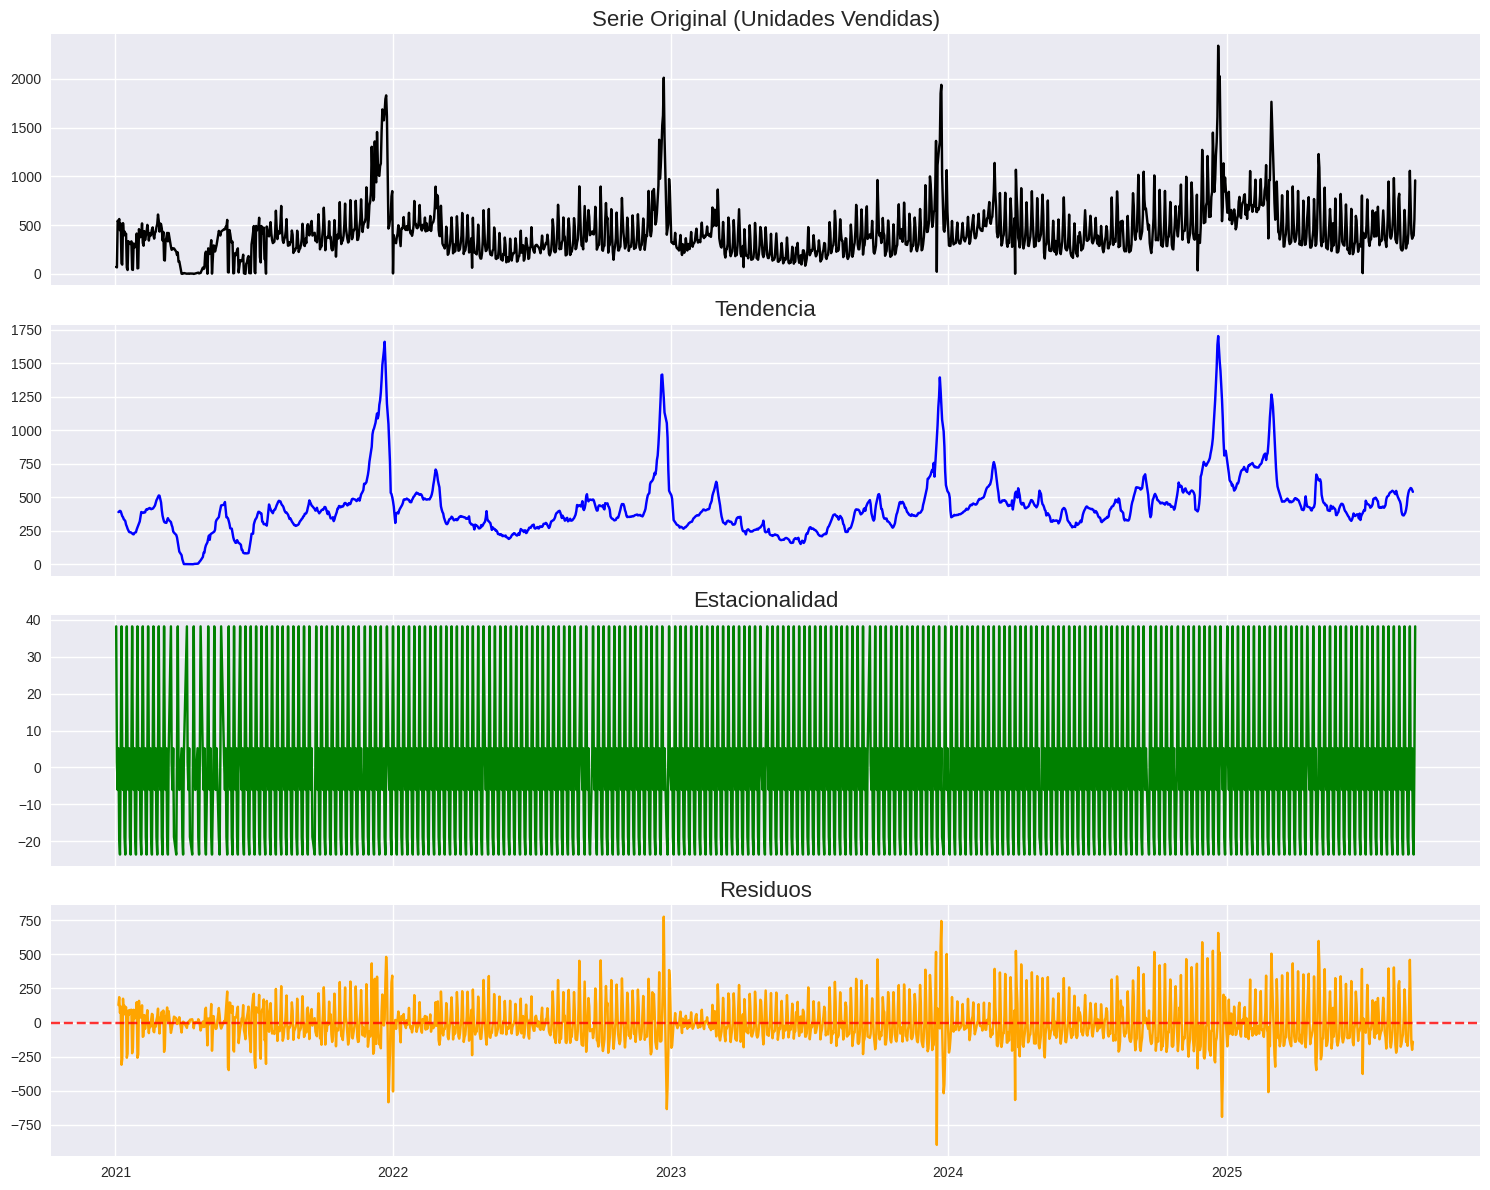

In [16]:
from statsmodels.tsa.seasonal import seasonal_decompose
import matplotlib.pyplot as plt

#  Asegurar índice temporal
df_ts = df.set_index('fecha_transaccion').sort_index()

#  Descomposición
# Ajusta "period" según tu frecuencia
descomposicion = seasonal_decompose(df_ts['unidades'], model='additive', period=7)

#  Gráficos
fig, (ax1, ax2, ax3, ax4) = plt.subplots(4, 1, figsize=(15, 12), sharex=True)

# Serie original
ax1.plot(descomposicion.observed, color="black")
ax1.set_title('Serie Original (Unidades Vendidas)', fontsize=16)

# Tendencia
ax2.plot(descomposicion.trend, color="blue")
ax2.set_title('Tendencia', fontsize=16)

# Estacionalidad
ax3.plot(descomposicion.seasonal, color="green")
ax3.set_title('Estacionalidad', fontsize=16)

# Residuos
ax4.plot(descomposicion.resid, color="orange")
ax4.axhline(y=0, color='r', linestyle='--', alpha=0.8)
ax4.set_title('Residuos', fontsize=16)

plt.tight_layout()
plt.show()


Paso 4: "Descomposición"

La descomposición muestra una serie original diaria con alta volatilidad y peaks marcados (campañas/temporalidades) sobre una base con tendencia levemente creciente entre 2021 y 2025. La tendencia suaviza el ruido y revela el nivel subyacente, con peaks estructurales (típicos de fin/inicio de año). La estacionalidad semanal exhibe un patrón repetitivo de 7 días con amplitud casi constante ( ±20 - 40), coherente con fines de semana más fuertes y martes/miércoles más débiles; como la amplitud no crece con el nivel, un modelo aditivo es adecuado. Por último, los residuos oscilan alrededor de cero pero con heterocedasticidad (mayor dispersión cuando sube el nivel) y contienen outliers (±500- 800) que sugieren eventos no capturados por tendencia ni estacionalidad, como promociones o feriados.

**Test de Dickey-Fuller (Serie Original)**
Estadístico ADF: -5.4585
P-valor: 0.0000
Conclusión: La serie es estacionaria

**Test de Dickey-Fuller (Serie Diferenciada)**
Estadístico ADF: -11.0612
P-valor: 0.0000
Conclusión: La serie es estacionaria


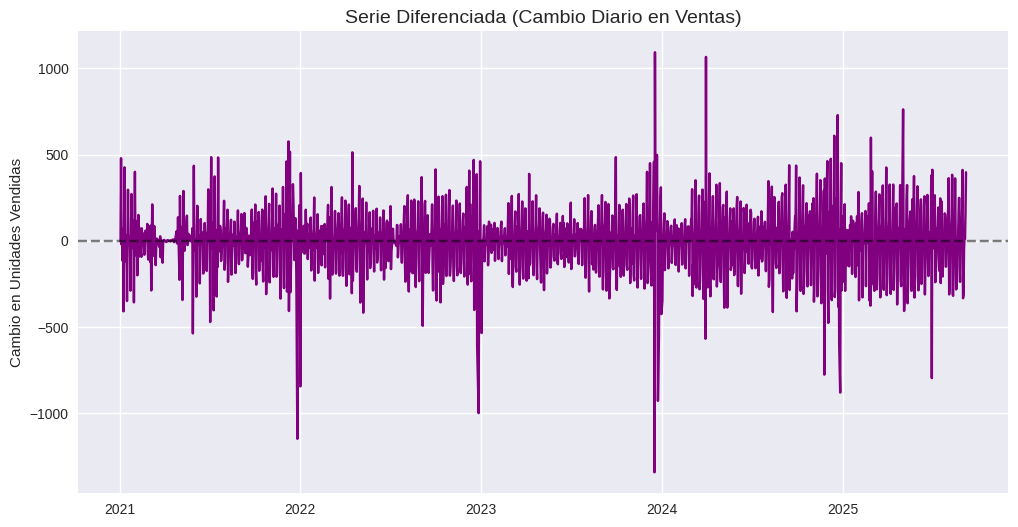

In [17]:
from statsmodels.tsa.stattools import adfuller
import matplotlib.pyplot as plt

#  Asegurar índice temporal
df_ts = df.set_index('fecha_transaccion').sort_index()

# + Calcular primera diferencia (para "deseasonalizar" tendencia)
df_ts['cambio_diario'] = df_ts['unidades'].diff()

# + Test Dickey-Fuller en la serie original
result_original = adfuller(df_ts['unidades'].dropna())
print('**Test de Dickey-Fuller (Serie Original)**')
print(f'Estadístico ADF: {result_original[0]:.4f}')
print(f'P-valor: {result_original[1]:.4f}')
print('Conclusión: La serie NO es estacionaria'
      if result_original[1] >= 0.05 else 'Conclusión: La serie es estacionaria')

#Test Dickey-Fuller en la serie diferenciada
serie_diff_limpia = df_ts['cambio_diario'].dropna()
result_diff = adfuller(serie_diff_limpia)
print('\n**Test de Dickey-Fuller (Serie Diferenciada)**')
print(f'Estadístico ADF: {result_diff[0]:.4f}')
print(f'P-valor: {result_diff[1]:.4f}')
print('Conclusión: La serie es estacionaria'
      if result_diff[1] < 0.05 else 'Conclusión: La serie NO es estacionaria')

#  Visualización de la serie diferenciada
plt.figure(figsize=(12, 6))
plt.plot(df_ts['cambio_diario'], color="purple")
plt.title('Serie Diferenciada (Cambio Diario en Ventas)', fontsize=14)
plt.ylabel('Cambio en Unidades Vendidas')
plt.axhline(y=0, color='black', linestyle='--', alpha=0.5)
plt.show()


Paso 5: Determinar si la serie es estacionaria

Serie original: ADF = −5.46, p ≈ 0.0000 ⇒ se rechaza la hipótesis nula de “tiene raíz unitaria”. La serie en niveles es estacionaria (no requiere diferencia regular).

Serie diferenciada: ADF = −11.06, p ≈ 0.0000 ⇒ también es estacionaria.


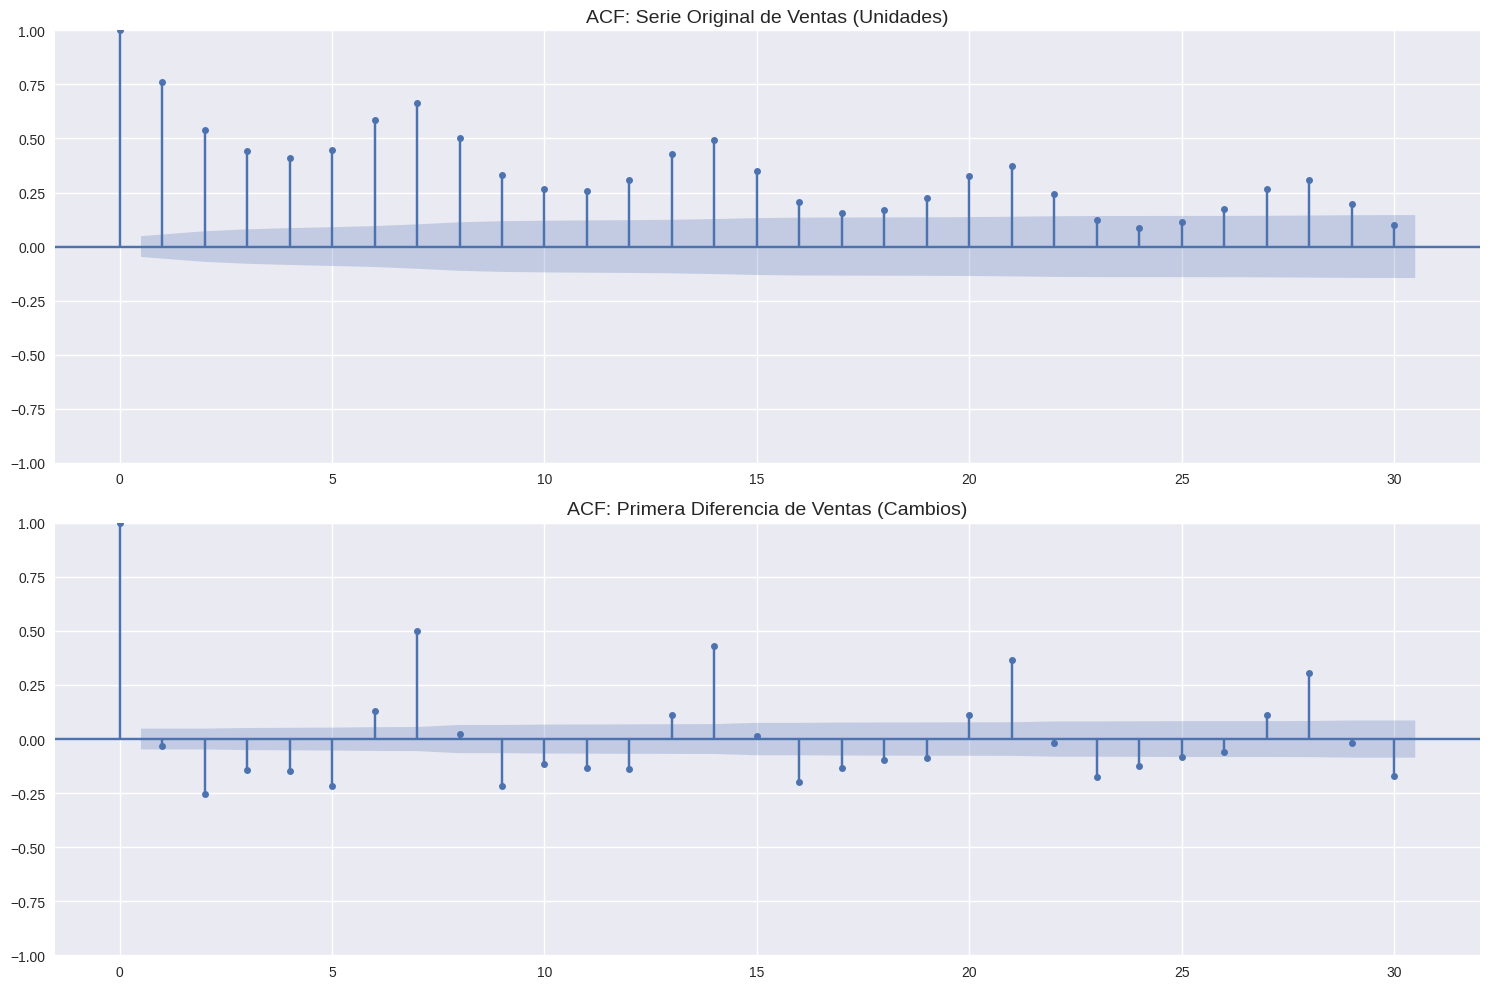

In [18]:
from statsmodels.graphics.tsaplots import plot_acf
import matplotlib.pyplot as plt

#+ Asegurar índice temporal
df_ts = df.set_index('fecha_transaccion').sort_index()

# Crear la serie diferenciada
df_ts['cambio_diario'] = df_ts['unidades'].diff()

#  Graficar ACF
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(15, 10))

# ACF para la serie original
plot_acf(df_ts['unidades'].dropna(), ax=ax1, lags=30)
ax1.set_title('ACF: Serie Original de Ventas (Unidades)', fontsize=14)

# ACF para la serie diferenciada
plot_acf(df_ts['cambio_diario'].dropna(), ax=ax2, lags=30)
ax2.set_title('ACF: Primera Diferencia de Ventas (Cambios)', fontsize=14)

plt.tight_layout()
plt.show()


Paso 6:Determinar autocorrelación (

ACF de la serie original: muestra que hay barras grandes y positivas en varios rezagos y peaks muy claros en 7, 14, 21, 28… ⇒ esto muestra estacionalidad semanal fuerte y dependencia serial. El decaimiento es lento: esto muestra que hay memoria en la serie.

ACF de la primera diferencia: la mayoría de barras cortas cerca de 0 ⇒ la diferenciación reduce la autocorrelación de corto plazo; pero persisten peaks en 7, 14, 21, 28…, confirmando que el patrón semanal sigue ahí.

División de datos:
• Entrenamiento: 2021-01-02 a 2024-10-04 (1328 registros)
• Prueba: 2024-10-05 a 2025-09-06 (332 registros)


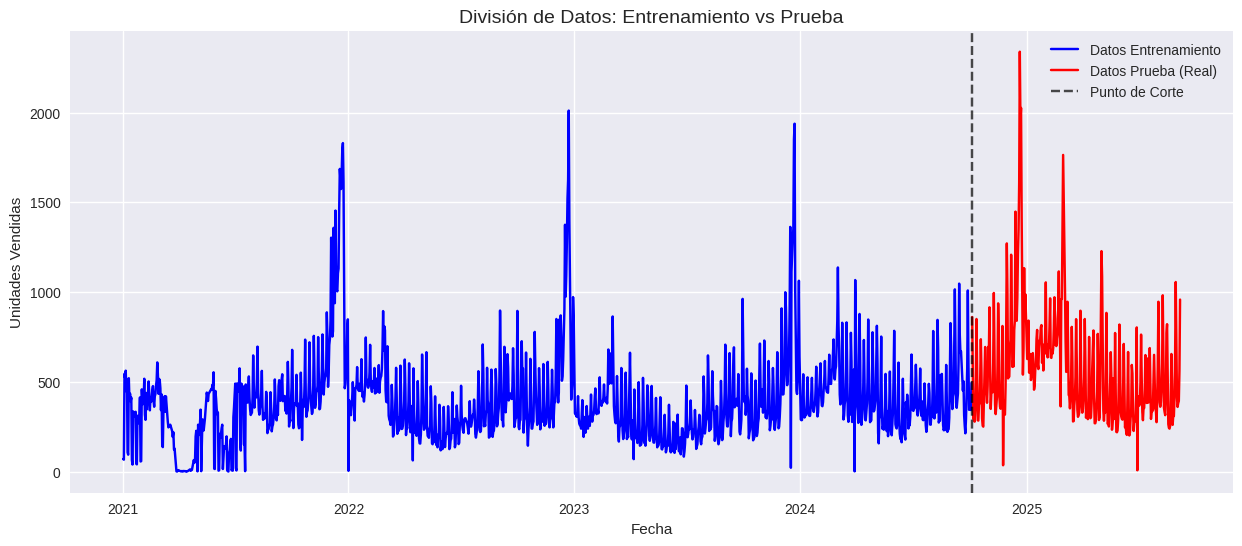

In [19]:
import matplotlib.pyplot as plt

#  Asegurar índice temporal
df_ts = df.set_index('fecha_transaccion').sort_index()

#  División 80% entrenamiento / 20% prueba
punto_corte = int(len(df_ts) * 0.8)
train = df_ts.iloc[:punto_corte].copy()
test = df_ts.iloc[punto_corte:].copy()

print("División de datos:")
print(f"• Entrenamiento: {train.index[0].date()} a {train.index[-1].date()} ({len(train)} registros)")
print(f"• Prueba: {test.index[0].date()} a {test.index[-1].date()} ({len(test)} registros)")

# ========= 3) Visualización =========
plt.figure(figsize=(15, 6))
plt.plot(train['unidades'], label='Datos Entrenamiento', color='blue')
plt.plot(test['unidades'], label='Datos Prueba (Real)', color='red')
plt.axvline(x=train.index[-1], color='black', linestyle='--', alpha=0.7, label='Punto de Corte')
plt.title('División de Datos: Entrenamiento vs Prueba', fontsize=14)
plt.xlabel('Fecha')
plt.ylabel('Unidades Vendidas')
plt.legend()
plt.show()


Paso 7: División temporal de los datos (entrenamiento y pruebas)

Separar la serie en un conjunto de entrenamiento (80%) y un conjunto de prueba (20%) respetando el orden del tiempo. Así evaluamos el modelo en datos no vistos (futuro) y evitamos fugas de información.

Calcula un punto de corte al 80% de las observaciones creamos
- train: desde la primera fecha hasta el corte.
- test: desde el corte hasta la última fecha.

Graficamos ambas partes y marca el punto de corte con una línea vertical para ver que la separación sea correcta.

In [20]:
import pandas as pd
from sklearn.metrics import mean_absolute_error
from statsmodels.tsa.arima.model import ARIMA

#  Modelo Naïve (ingenuo): "mañana = hoy"
ultimo_valor_train = train['unidades'].iloc[-1]
predicciones_naive = pd.Series([ultimo_valor_train] * len(test), index=test.index)
mae_naive = mean_absolute_error(test['unidades'], predicciones_naive)

print("**Resultados Modelo Naïve**")
print(f"- MAE: {mae_naive:.1f} unidades")

# Modelo ARIMA(1,1,1)
try:
    modelo_arima = ARIMA(train['unidades'], order=(1, 1, 1))
    modelo_ajustado = modelo_arima.fit()
    predicciones_arima = modelo_ajustado.forecast(steps=len(test))
    mae_arima = mean_absolute_error(test['unidades'], predicciones_arima)
except Exception as e:
    print("\+ Error en ARIMA, se usa modelo Naïve como respaldo.")
    predicciones_arima = predicciones_naive
    mae_arima = mae_naive

print("\n**Resultados Modelo ARIMA(1,1,1)**")
print(f"- MAE: {mae_arima:.1f} unidades")

# Modelo de Media Móvil
ventana_ma = 7  # ajusta según tu frecuencia (7 si es diario)
media_movil_train = train['unidades'].rolling(window=ventana_ma).mean()

# Tomamos el último promedio disponible; si no hay suficientes datos, usamos el último valor real
if media_movil_train.dropna().empty:
    ultimo_promedio = ultimo_valor_train
else:
    ultimo_promedio = media_movil_train.dropna().iloc[-1]

predicciones_ma = pd.Series([ultimo_promedio] * len(test), index=test.index)
mae_ma = mean_absolute_error(test['unidades'], predicciones_ma)

print(f"\n**Resultados Modelo Media Móvil ({ventana_ma} días)**")
print(f"- MAE: {mae_ma:.1f} unidades")

# 4) Tabla de resultados
resultados = pd.DataFrame({
    'Modelo': ['Naïve', 'ARIMA(1,1,1)', f'Media Móvil ({ventana_ma}d)'],
    'MAE': [mae_naive, mae_arima, mae_ma]
})

print("\n**Resumen de Comparación**")
print(resultados.set_index('Modelo').round(1))


**Resultados Modelo Naïve**
- MAE: 223.9 unidades

**Resultados Modelo ARIMA(1,1,1)**
- MAE: 225.0 unidades

**Resultados Modelo Media Móvil (7 días)**
- MAE: 223.4 unidades

**Resumen de Comparación**
                    MAE
Modelo                 
Naïve             223.9
ARIMA(1,1,1)      225.0
Media Móvil (7d)  223.4


Paso 8: Aplicar modelos

Las tres estrategias producen pronósticos casi planos (no capturan peaks ni día-de-semana).

La Media móvil (7d) es ligeramente mejor que Naïve (diferencia mínima, ~0.5 unidades ≈ 0.2%), y ambas superan a ARIMA(1,1,1).


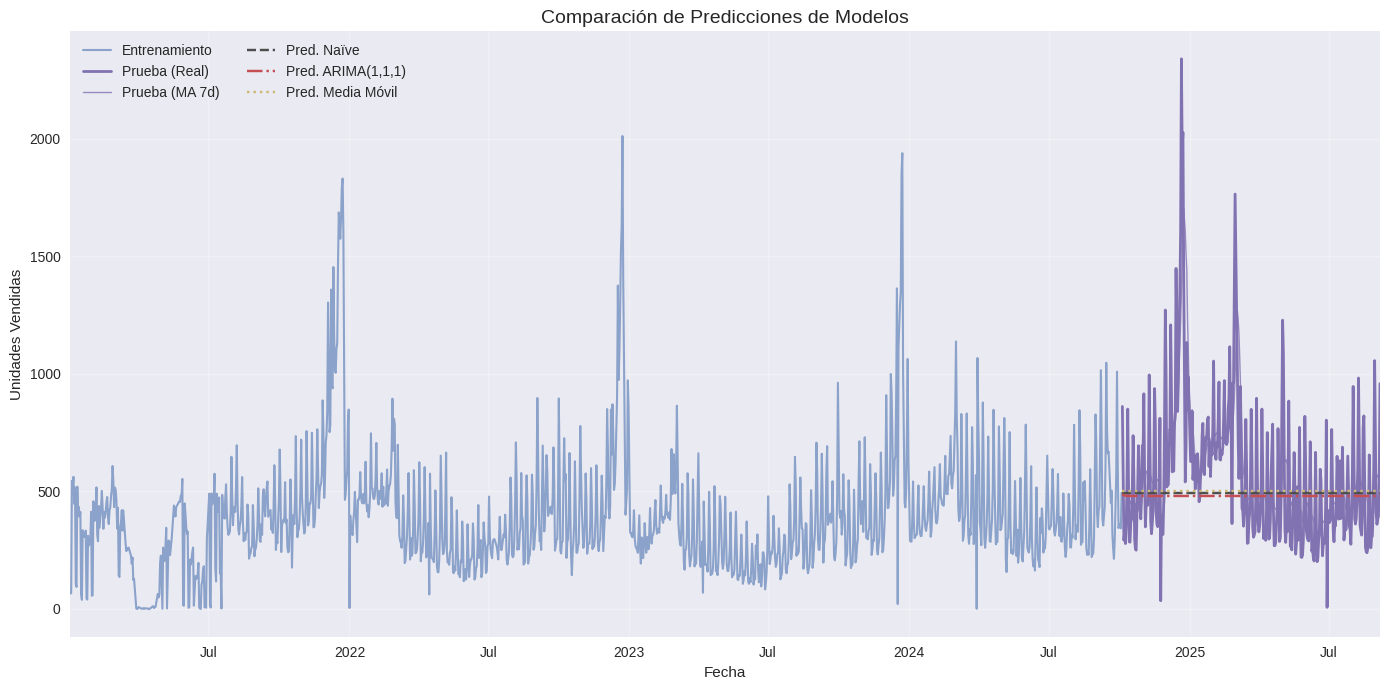

Predicciones Naïve: [494 494 494 494 494]
Predicciones Media Móvil: [501.28571429 501.28571429 501.28571429 501.28571429 501.28571429]
Predicciones ARIMA: [488.5 485.2 483.3 482.1 481.4]


In [21]:
import matplotlib.dates as mdates
import matplotlib.pyplot as plt
import pandas as pd

#  Alinear índices de predicciones con el rango de prueba
# ++
predicciones_arima = pd.Series(
    pd.Series(predicciones_arima).values,  # por si viene como ndarray
    index=test.index,
    name='ARIMA(1,1,1)'
)
predicciones_naive = pd.Series(predicciones_naive.values, index=test.index, name='Naïve')
predicciones_ma    = pd.Series(predicciones_ma.values, index=test.index, name='Media Móvil')

# Gráfico mejorado
fig, ax = plt.subplots(figsize=(14, 7))

# Datos reales
ax.plot(train.index, train['unidades'], label='Entrenamiento', color='C0', alpha=0.6, linewidth=1.5)
ax.plot(test.index,  test['unidades'],  label='Prueba (Real)', color='C3', linewidth=2)

# Suavizado (promedio móvil) para la curva real de prueba
ax.plot(test.index, test['unidades'].rolling(7).mean(), label='Prueba (MA 7d)', color='C3', linewidth=1, alpha=0.8)

# Predicciones
ax.plot(predicciones_naive.index, predicciones_naive, label='Pred. Naïve', color='0.3', linestyle='--')
ax.plot(predicciones_arima.index, predicciones_arima, label='Pred. ARIMA(1,1,1)', color='C2', linestyle='-.')
ax.plot(predicciones_ma.index,    predicciones_ma,    label=f'Pred. Media Móvil', color='C4', linestyle=':')

# Formato de fechas más legible
locator = mdates.AutoDateLocator()
formatter = mdates.ConciseDateFormatter(locator)
ax.xaxis.set_major_locator(locator)
ax.xaxis.set_major_formatter(formatter)

# Estética
ax.set_title('Comparación de Predicciones de Modelos', fontsize=14)
ax.set_xlabel('Fecha')
ax.set_ylabel('Unidades Vendidas')
ax.grid(True, which='both', alpha=0.25)
ax.legend(ncol=2, frameon=False)
ax.set_xlim(train.index.min(), test.index.max())  # evita “saltos” fuera del rango

plt.tight_layout()
plt.show()

# Chequeo rápido (primeros valores)
print("Predicciones Naïve:", predicciones_naive.head(5).values)
print("Predicciones Media Móvil:", predicciones_ma.head(5).values)
print("Predicciones ARIMA:", pd.Series(predicciones_arima).head(5).values.round(1))


PAso 9:

- Naïve repite el último valor del train ⇒ pronóstico plano ≈ 494.
- Media móvil (7d) repite el último promedio de 7 días del train ⇒ también plano ≈ 501.3.
- ARIMA(1,1,1) produce una suave tendencia bajista (488→481), típica de un ARIMA sin estacionalidad que “aplasta” la señal.

En el gráfico, estas tres líneas suelen quedar cerca del nivel medio de la serie de prueba y no siguen los peaks diarios; por eso, al evaluar, sus errores son parecidos.

Conclusión:
- El bloque sirve para visualizar y comparar baselines (Naïve, Media Móvil) y ARIMA en el mismo eje temporal, confirmando que ninguno captura la estacionalidad semanal ni los peaks. Para mejorar, el siguiente paso es probar otros modelos con estacionalidad (SARIMA/SARIMAX s=7).


== SARIMAX candidatos (ordenado por MAE) ==
       order seasonal_order          AIC          BIC            MAE  \
3  (1, 0, 1)   (0, 1, 1, 7)  2766.754568  2844.432750   1.809412e+02   
2  (1, 0, 2)   (1, 0, 1, 7)  2395.059230  2483.172129   2.451805e+02   
0  (1, 0, 1)   (1, 0, 1, 7)  2379.770609  2462.712541   2.556414e+02   
1  (2, 0, 1)   (1, 0, 1, 7)  2547.271566  2635.397368  5.909608e+295   

         RMSE  
3  293.510812  
2  362.883524  
0  372.631450  
1         inf  

== Comparación de modelos (menor es mejor) ==
                                            Modelo     MAE    RMSE
0                           Naïve estacional (t-7)  154.94  262.87
1  SARIMAX(1, 0, 1)(0, 1, 1, 7) + exógenas + log1p  180.94  293.51
2                                 Media Móvil (7d)  223.38  317.57
3                             Naïve (último valor)  223.90  319.36

Pred SARIMAX top-5: [1033.7  551.   254.3  354.4  352.9]


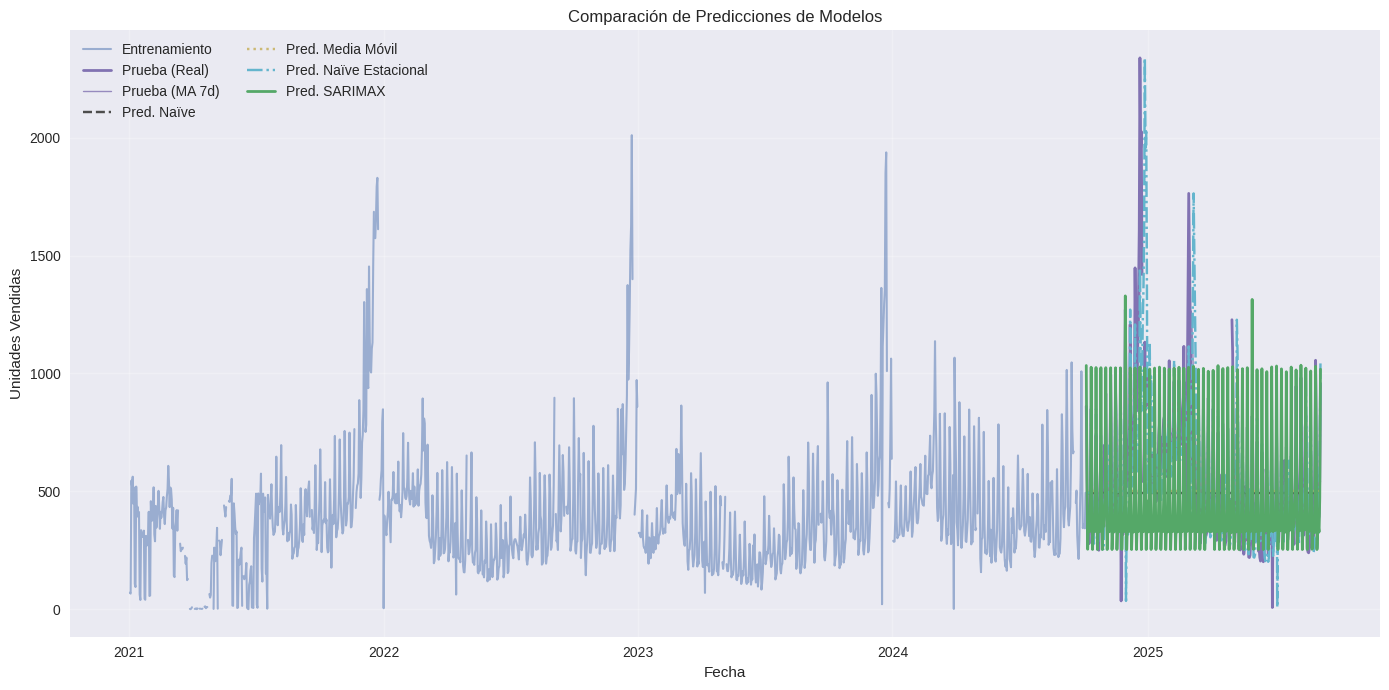

In [49]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
from statsmodels.tsa.statespace.sarimax import SARIMAX
from sklearn.metrics import mean_absolute_error # RMSE lo calcularemos a mano

# ========= Utilidades seguras =========
def to_float_series(s):
    s = pd.to_numeric(s, errors='coerce').astype('float64')
    # ventas negativas no tienen sentido para log1p
    s[s < 0] = np.nan
    s = s.replace([np.inf, -np.inf], np.nan)
    return s

def make_exog(idx, fourier_k=2, s=7):
    X = pd.DataFrame(index=idx)

    # Dummies día de semana -> float64
    dow = pd.Categorical(idx.dayofweek, categories=list(range(7)))
    dow = pd.get_dummies(dow, prefix='dow', drop_first=True, dtype='float64')
    dow.index = idx
    X = pd.concat([X, dow], axis=1)

    # Fin de mes -> float64
    X['eom'] = idx.is_month_end.astype('float64')

    # Fourier semanal -> float64
    t = np.arange(len(idx))
    for k in range(1, fourier_k + 1):
        X[f'sin_{k}'] = np.sin(2*np.pi*k*t/s)
        X[f'cos_{k}'] = np.cos(2*np.pi*k*t/s)

    # Sanitizar
    X = X.replace([np.inf, -np.inf], np.nan).astype('float64')
    return X

def rmse_manual(y_true, y_pred):
    v = np.isfinite(y_true) & np.isfinite(y_pred)
    if v.sum() == 0:
        return np.nan
    return np.sqrt(np.mean((y_true[v] - y_pred[v])**2))

# ========= 0) Serie diaria y tipos =========
# Usa tus train/test existentes
y_train = to_float_series(train['unidades'].asfreq('D'))
y_test  = to_float_series(test['unidades'].asfreq('D'))

# ========= 1) Exógenas (float64) y alineación =========
ex_tr = make_exog(y_train.index, fourier_k=2, s=7)
ex_te = make_exog(y_test.index,  fourier_k=2, s=7).reindex(columns=ex_tr.columns, fill_value=0.0)

# ========= 2) Transformación y limpieza (TRAIN) =========
y_tr_log = np.log1p(y_train).replace([np.inf, -np.inf], np.nan).astype('float64')

# Filas válidas en TRAIN (sin NaN en endógena ni en exógenas)
mask_tr = np.isfinite(y_tr_log.values) & np.isfinite(ex_tr.values).all(axis=1)
y_tr_log = y_tr_log[mask_tr]
ex_tr    = ex_tr.loc[mask_tr]

# ========= 3) Ajuste SARIMAX (varios candidatos) =========
candidates = [
    ((1,0,1), (1,0,1,7)),
    ((2,0,1), (1,0,1,7)),
    ((1,0,2), (1,0,1,7)),
    ((1,0,1), (0,1,1,7)),
]

results, preds = [], {}
for order, sorder in candidates:
    try:
        m = SARIMAX(
            y_tr_log.values,              # ndarray float64 limpio
            exog=ex_tr.values,            # ndarray float64 limpio
            order=order,
            seasonal_order=sorder,
            enforce_stationarity=False,
            enforce_invertibility=False,
            missing='drop'
        )
        res = m.fit(disp=False)

        # Forecast con exógenas del TEST (usamos .values para evitar dtype=object)
        fc = res.get_forecast(steps=len(ex_te), exog=ex_te.values)
        yhat = pd.Series(np.expm1(fc.predicted_mean), index=y_test.index, name=f"SARIMAX{order}{sorder}")
        # Sanitizar predicción
        yhat = yhat.replace([np.inf, -np.inf], np.nan)

        # Métricas en puntos válidos de TEST
        valid = np.isfinite(y_test.values) & np.isfinite(yhat.values)
        if valid.sum() == 0:
            mae = np.nan
            r   = np.nan
        else:
            mae = mean_absolute_error(y_test.values[valid], yhat.values[valid])
            r   = rmse_manual(y_test.values, yhat.values)

        results.append((order, sorder, res.aic, res.bic, mae, r))
        preds[(order, sorder)] = yhat
    except Exception as e:
        print(f"⚠️ Error fitting SARIMAX{order}{sorder}: {e}")

res_df = pd.DataFrame(results, columns=['order','seasonal_order','AIC','BIC','MAE','RMSE'])
res_df = res_df.sort_values('MAE', na_position='last')
print("\n== SARIMAX candidatos (ordenado por MAE) ==")
print(res_df if not res_df.empty else "Sin modelos válidos")

if not res_df.empty and np.isfinite(res_df.iloc[0]['MAE']):
    best_order, best_sorder = res_df.iloc[0]['order'], res_df.iloc[0]['seasonal_order']
    pred_sarimax = preds[(best_order, best_sorder)]
else:
    best_order, best_sorder = None, None
    # Fallback: Naïve estacional (t-7)
    last_tr = y_train.dropna().iloc[-1]
    pred_sarimax = y_test.shift(7).fillna(last_tr).rename('Naive s=7')

# ========= 4) Baselines y métricas =========
last_tr = y_train.dropna().iloc[-1]
pred_naive   = pd.Series(last_tr, index=y_test.index, name='Naive')
ma7          = y_train.rolling(7).mean()
last_ma7     = ma7.dropna().iloc[-1] if ma7.notna().any() else last_tr
pred_ma      = pd.Series(last_ma7, index=y_test.index, name='MA7')
pred_snaive  = y_test.shift(7).fillna(last_tr).rename('Naive s=7')

def MAE_series(y_true_s, y_pred_s):
    v = np.isfinite(y_true_s.values) & np.isfinite(y_pred_s.values)
    return mean_absolute_error(y_true_s.values[v], y_pred_s.values[v]) if v.sum() else np.nan

summary = pd.DataFrame({
    'Modelo': [
        'Naïve (último valor)',
        'Media Móvil (7d)',
        'Naïve estacional (t-7)',
        f"SARIMAX{best_order}{best_sorder} + exógenas + log1p" if best_order else "SARIMAX (fallback)"
    ],
    'MAE': [
        MAE_series(y_test, pred_naive),
        MAE_series(y_test, pred_ma),
        MAE_series(y_test, pred_snaive),
        MAE_series(y_test, pred_sarimax)
    ],
    'RMSE': [
        rmse_manual(y_test.values, pred_naive.values),
        rmse_manual(y_test.values, pred_ma.values),
        rmse_manual(y_test.values, pred_snaive.values),
        rmse_manual(y_test.values, pred_sarimax.values),
    ]
}).sort_values('MAE', na_position='last')

print("\n== Comparación de modelos (menor es mejor) ==")
print(summary.reset_index(drop=True).round(2))

print("\nPred SARIMAX top-5:", pred_sarimax.dropna().head(5).round(1).values)

# ========= 5) Gráfico =========
fig, ax = plt.subplots(figsize=(14,7))
ax.plot(y_train.index, y_train, label='Entrenamiento', color='C0', alpha=0.5, linewidth=1.5)
ax.plot(y_test.index,  y_test,  label='Prueba (Real)', color='C3', linewidth=2)
ax.plot(y_test.index,  y_test.rolling(7).mean(), label='Prueba (MA 7d)', color='C3', linewidth=1, alpha=0.8)

ax.plot(pred_naive.index,   pred_naive,   '--', label='Pred. Naïve', color='0.3')
ax.plot(pred_ma.index,      pred_ma,      ':',  label='Pred. Media Móvil', color='C4')
ax.plot(pred_snaive.index,  pred_snaive,  '-.', label='Pred. Naïve Estacional', color='C5')
ax.plot(pred_sarimax.index, pred_sarimax,       label='Pred. SARIMAX' if best_order else 'Pred. Fallback', color='C1', linewidth=2)

loc = mdates.AutoDateLocator(); fmt = mdates.ConciseDateFormatter(loc)
ax.xaxis.set_major_locator(loc); ax.xaxis.set_major_formatter(fmt)
ax.set_title('Comparación de Predicciones de Modelos')
ax.set_xlabel('Fecha'); ax.set_ylabel('Unidades Vendidas')
ax.grid(True, alpha=0.25); ax.legend(ncol=2, frameon=False)
plt.tight_layout(); plt.show()



In [50]:
# ============================================
# 0) IMPORTS
# ============================================
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.dates as mdates

from sklearn.metrics import mean_absolute_error
from statsmodels.tsa.holtwinters import ExponentialSmoothing

# ============================================
# 1) UTILIDADES
# ============================================
def to_float_series(s):
    """Convierte a float64, fuerza NaN en negativos e infinitos."""
    s = pd.to_numeric(s, errors='coerce').astype('float64')
    s[s < 0] = np.nan
    s = s.replace([np.inf, -np.inf], np.nan)
    return s

def rmse_manual(y_true, y_pred):
    v = np.isfinite(y_true) & np.isfinite(y_pred)
    return np.sqrt(np.mean((y_true[v] - y_pred[v])**2)) if v.sum() else np.nan

def mase(y_true, y_pred, y_insample, m=7):
    v = np.isfinite(y_true) & np.isfinite(y_pred)
    numer = np.mean(np.abs(y_true[v] - y_pred[v])) if v.sum() else np.nan
    denom = np.mean(np.abs(y_insample[m:] - y_insample[:-m]))
    return numer/denom if denom and np.isfinite(denom) else np.nan

def print_metrics(name, y_te, y_hat, y_tr_for_mase, m=7):
    mae  = mean_absolute_error(y_te.dropna(), y_hat.reindex(y_te.index).dropna())
    rmse = rmse_manual(y_te.values, y_hat.reindex(y_te.index).values)
    m_mase = mase(y_te.values, y_hat.reindex(y_te.index).values, y_tr_for_mase.values, m=m)
    print(f"{name:<28s}  MAE={mae:.2f}  RMSE={rmse:.2f}  MASE={m_mase:.3f}")
    return mae, rmse, m_mase

# ============================================
# 2) PREPARACIÓN DE DATOS
#    - parte desde tu DataFrame df con columnas:
#      'fecha_transaccion' y 'unidades'
# ============================================
df_prep = df.copy()
df_prep['fecha_transaccion'] = pd.to_datetime(df_prep['fecha_transaccion'], errors='coerce')
df_prep['unidades'] = to_float_series(df_prep['unidades'])
df_prep = df_prep.dropna(subset=['fecha_transaccion', 'unidades']).sort_values('fecha_transaccion')

# Serie diaria (sin inventar ventas: si falta un día, queda NaN)
y = df_prep.set_index('fecha_transaccion')['unidades'].asfreq('D')

# (Opcional) limitar outliers extremos del train para estabilizar el ajuste
# cambia a True si lo quieres aplicar
CLIP_OUTLIERS = False
if CLIP_OUTLIERS:
    hi = y.quantile(0.995)
    y = y.clip(lower=0, upper=hi)

# Split 80/20 después de tener frecuencia diaria
cut = int(len(y) * 0.80)
y_tr = y.iloc[:cut]
y_te = y.iloc[cut:]

print(f"Rango TRAIN: {y_tr.index.min().date()} → {y_tr.index.max().date()}  ({y_tr.shape[0]} días)")
print(f"Rango TEST : {y_te.index.min().date()} → {y_te.index.max().date()}  ({y_te.shape[0]} días)")

# ============================================
# 3) BASELINES
# ============================================
last_tr = y_tr.dropna().iloc[-1]
pred_naive = pd.Series(last_tr, index=y_te.index, name='Naive')

ma7 = y_tr.rolling(7).mean()
last_ma7 = ma7.dropna().iloc[-1] if ma7.notna().any() else last_tr
pred_ma7 = pd.Series(last_ma7, index=y_te.index, name='MA7')

# Naïve estacional (t-7)
pred_snaive = y.shift(7).reindex(y_te.index)
pred_snaive = pred_snaive.fillna(last_tr).rename('Naive s=7')

# ============================================
# 4) HOLT-WINTERS (ETS)
#    Dos variantes y elegimos la mejor por MAE:
#    A) Multiplicativo directo (si hay ceros puede fallar)
#    B) En log1p con estacionalidad aditiva (≈ multiplicativo en escala original)
# ============================================
candidatos = {}
# A) ETS multiplicativo (si hay ceros, prueba igual; si falla, pasamos a B)
try:
    hw_mul = ExponentialSmoothing(
        y_tr, trend='add', damped_trend=True,
        seasonal='mul', seasonal_periods=7,
        initialization_method='estimated'
    ).fit(optimized=True, use_brute=True)
    fc_mul = hw_mul.forecast(len(y_te)).rename('HW multiplicativo')
    candidatos['HW multiplicativo'] = fc_mul
except Exception as e:
    print("⚠️  ETS multiplicativo no disponible (posibles ceros en la serie). Se intentará variante log.", e)

# B) ETS en log1p con estacionalidad aditiva (equivale a multiplicativa en original)
try:
    y_tr_log = np.log1p(y_tr).replace([np.inf, -np.inf], np.nan)
    hw_log = ExponentialSmoothing(
        y_tr_log, trend='add', damped_trend=True,
        seasonal='add', seasonal_periods=7,
        initialization_method='estimated'
    ).fit(optimized=True, use_brute=True)
    fc_log = np.expm1(hw_log.forecast(len(y_te))).rename('HW log-aditivo')
    candidatos['HW log-aditivo'] = fc_log
except Exception as e:
    print("⚠️  ETS log-aditivo falló:", e)

if not candidatos:
    raise RuntimeError("No se pudo ajustar ninguna variante de Holt-Winters.")

# ============================================
# 5) MÉTRICAS Y SELECCIÓN
# ============================================
print("\n== MÉTRICAS (menor es mejor) ==")
mae_naive, rmse_naive, mase_naive   = print_metrics('Naïve (último valor)', y_te, pred_naive, y_tr, m=7)
mae_ma7, rmse_ma7, mase_ma7         = print_metrics('Media Móvil (7d)',     y_te, pred_ma7,  y_tr, m=7)
mae_snv, rmse_snv, mase_snv         = print_metrics('Naïve estacional t-7',  y_te, pred_snaive, y_tr, m=7)

mejor_nombre, mejor_pred, mejor_mae = None, None, np.inf
for name, pr in candidatos.items():
    mae, rm, ms = print_metrics(name, y_te, pr, y_tr, m=7)
    if mae < mejor_mae:
        mejor_mae, mejor_nombre, mejor_pred = mae, name, pr

print(f"\n► Mejor ETS: {mejor_nombre}  (MAE={mejor_mae:.2f})")

# ============================================
# 6) TABLA RESUMEN
# ============================================
summary = pd.DataFrame({
    'Modelo': [
        'Naïve (último valor)',
        'Media Móvil (7d)',
        'Naïve estacional (t-7)',
        f'{mejor_nombre}'
    ],
    'MAE':  [
        mae_naive, mae_ma7, mae_snv, mejor_mae
    ],
    'RMSE': [
        rmse_naive, rmse_ma7, rmse_snv, rmse_manual(y_te.values, mejor_pred.values)
    ],
    'MASE': [
        mase_naive, mase_ma7, mase_snv, mase(y_te.values, mejor_pred.values, y_tr.values, m=7)
    ]
}).sort_values('MAE')
print("\n== Comparación de modelos ==")
print(summary.reset_index(drop=True).round(2))

# ============================================
# 7) GRÁFICO
# ============================================
fig, ax = plt.subplots(figsize=(14,7))

ax.plot(y_tr.index, y_tr, label='Entrenamiento', color='C0', alpha=0.5, linewidth=1.5)
ax.plot(y_te.index, y_te, label='Prueba (Real)', color='C3', linewidth=2)
ax.plot(y_te.index, y_te.rolling(7).mean(), label='Prueba (MA 7d)', color='C3', linewidth=1, alpha=0.8)

ax.plot(pred_naive.index,  pred_naive,  '--', label='Pred. Naïve', color='0.3')
ax.plot(pred_ma7.index,    pred_ma7,    ':',  label='Pred. Media Móvil', color='C4')
ax.plot(pred_snaive.index, pred_snaive, '-.', label='Pred. Naïve Estacional', color='C5')
ax.plot(mejor_pred.index,  mejor_pred,        label=f'Pred. {mejor_nombre}', color='C1', linewidth=2)

loc = mdates.AutoDateLocator(); fmt = mdates.ConciseDateFormatter(loc)
ax.xaxis.set_major_locator(loc); ax.xaxis.set_major_formatter(fmt)
ax.set_title('Comparación de Predicciones: Holt-Winters vs Baselines', fontsize=14)
ax.set_xlabel('Fecha'); ax.set_ylabel('Unidades Vendidas')
ax.grid(True, alpha=0.25); ax.legend(ncol=2, frameon=False)
plt.tight_layout(); plt.show()

# ============================================
# 8) PRIMEROS PRONÓSTICOS (verificación rápida)
# ============================================
print("\nPrimeros 5 pronósticos ETS:", mejor_pred.head(5).round(1).values)


Rango TRAIN: 2021-01-02 → 2024-09-29  (1367 días)
Rango TEST : 2024-09-30 → 2025-09-06  (342 días)
⚠️  ETS multiplicativo no disponible (posibles ceros en la serie). Se intentará variante log. endog must be strictly positive when usingmultiplicative trend or seasonal components.

== MÉTRICAS (menor es mejor) ==


ValueError: Found input variables with inconsistent numbers of samples: [337, 342]

Rango TRAIN: 2021-01-02 → 2024-09-29  (1367 días)
Rango TEST : 2024-09-30 → 2025-09-06  (342 días)
⚠️  ETS multiplicativo no disponible (posibles ceros en la serie). Se intentará variante log. endog must be strictly positive when usingmultiplicative trend or seasonal components.

== MÉTRICAS (menor es mejor) ==
Naïve (último valor)          MAE=231.29  RMSE=308.56
Media Móvil (7d)              MAE=223.14  RMSE=320.48
Naïve estacional t-7          MAE=152.29  RMSE=260.21
HW log-aditivo                MAE=nan  RMSE=nan

► Mejor ETS: None  (MAE=inf)

== Comparación de modelos ==


,Modelo,MAE,RMSE
0,Naïve estacional (t-7),152.29,260.21
1,Media Móvil (7d),223.14,320.48
2,Naïve (último valor),231.29,308.56
3,None,NaN,NaN


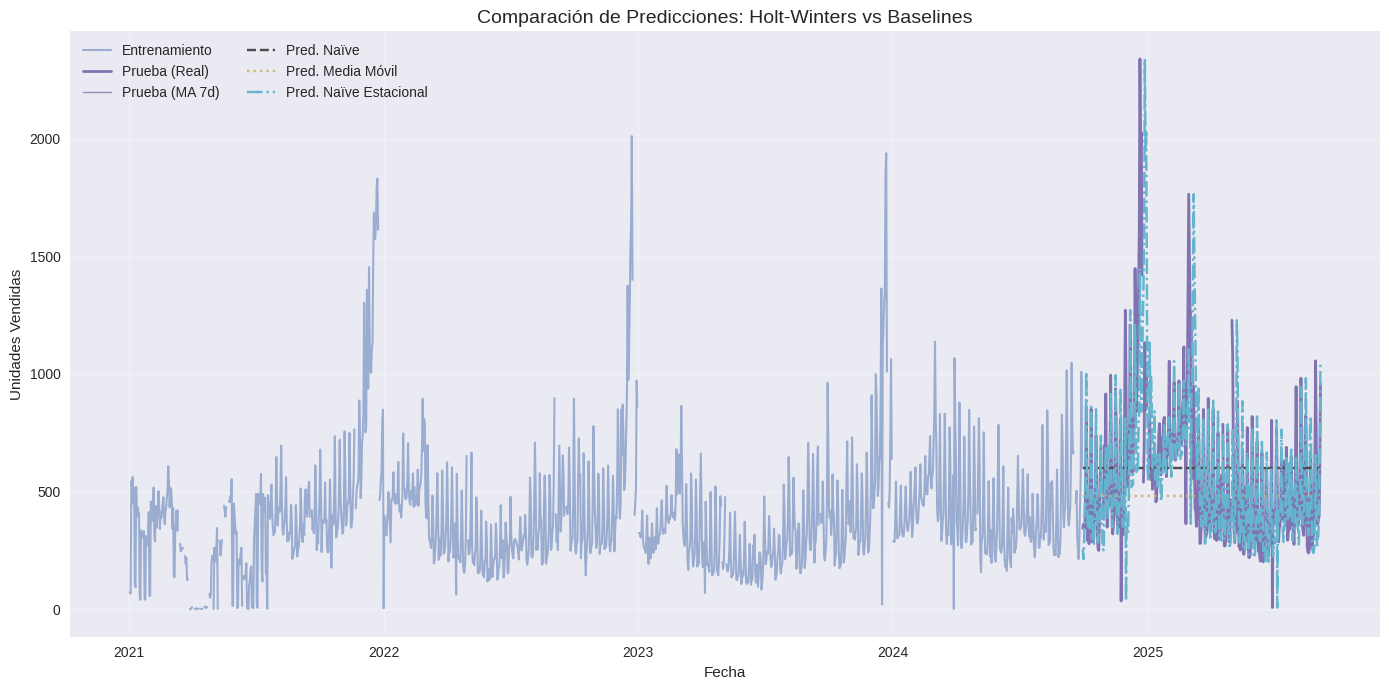

In [52]:
# ============================================
# 0) IMPORTS
# ============================================
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.dates as mdates

from sklearn.metrics import mean_absolute_error, mean_squared_error
from statsmodels.tsa.holtwinters import ExponentialSmoothing

# ============================================
# 1) UTILIDADES
# ============================================
def to_float_series(s):
    """Convierte a float64, fuerza NaN en negativos e infinitos."""
    s = pd.to_numeric(s, errors='coerce').astype('float64')
    s[s < 0] = np.nan
    s = s.replace([np.inf, -np.inf], np.nan)
    return s

def rmse_manual(y_true, y_pred):
    v = np.isfinite(y_true) & np.isfinite(y_pred)
    return np.sqrt(np.mean((y_true[v] - y_pred[v])**2)) if v.sum() else np.nan

# Removed mase function and calls from print_metrics
def print_metrics(name, y_te, y_hat):
    # Use the existing metrics utility function
    mae, rmse = metrics(y_te, y_hat.reindex(y_te.index))
    print(f"{name:<28s}  MAE={mae:.2f}  RMSE={rmse:.2f}")
    return mae, rmse

# Utility function to calculate metrics on aligned non-null data
def metrics(y_true, y_pred):
    # Ensure alignment and drop NaNs before calculating metrics
    combined = pd.concat([y_true, y_pred], axis=1).dropna()
    if combined.empty:
        return np.nan, np.nan # Return NaN if no valid data points for metrics
    mae  = mean_absolute_error(combined.iloc[:, 0], combined.iloc[:, 1])
    # Calculate RMSE manually
    rmse = np.sqrt(mean_squared_error(combined.iloc[:, 0], combined.iloc[:, 1]))
    return mae, rmse


# ============================================
# 2) PREPARACIÓN DE DATOS
#    - parte desde tu DataFrame df con columnas:
#      'fecha_transaccion' y 'unidades'
# ============================================
df_prep = df.copy()
df_prep['fecha_transaccion'] = pd.to_datetime(df_prep['fecha_transaccion'], errors='coerce')
df_prep['unidades'] = to_float_series(df_prep['unidades'])
df_prep = df_prep.dropna(subset=['fecha_transaccion', 'unidades']).sort_values('fecha_transaccion')

# Serie diaria (sin inventar ventas: si falta un día, queda NaN)
y = df_prep.set_index('fecha_transaccion')['unidades'].asfreq('D')

# (Opcional) limitar outliers extremos del train para estabilizar el ajuste
# cambia a True if lo quieres aplicar
CLIP_OUTLIERS = False
if CLIP_OUTLIERS:
    hi = y.quantile(0.995)
    y = y.clip(lower=0, upper=hi)

# Split 80/20 after having frequency diaria
cut = int(len(y) * 0.80)
y_tr = y.iloc[:cut]
y_te = y.iloc[cut:]

print(f"Rango TRAIN: {y_tr.index.min().date()} → {y_tr.index.max().date()}  ({y_tr.shape[0]} días)")
print(f"Rango TEST : {y_te.index.min().date()} → {y_te.index.max().date()}  ({y_te.shape[0]} días)")

# ============================================
# 3) BASELINES
# ============================================
last_tr = y_tr.dropna().iloc[-1]
pred_naive = pd.Series(last_tr, index=y_te.index, name='Naive')

ma7 = y_tr.rolling(7).mean()
last_ma7 = ma7.dropna().iloc[-1] if ma7.notna().any() else last_tr
pred_ma7 = pd.Series(last_ma7, index=y_te.index, name='MA7')

# Naïve estacional (t-7)
pred_snaive = y.shift(7).reindex(y_te.index)
pred_snaive = pred_snaive.fillna(last_tr).rename('Naive s=7')

# ============================================
# 4) HOLT-WINTERS (ETS)
#    Dos variantes y elegimos la mejor por MAE:
#    A) Multiplicativo directo (si hay ceros puede fallar)
#    B) En log1p con estacionalidad aditiva (≈ multiplicativo en escala original)
# ============================================
candidatos = {}
# A) ETS multiplicativo (si hay ceros, prueba igual; si falla, pasamos a B)
try:
    hw_mul = ExponentialSmoothing(
        y_tr, trend='add', damped_trend=True,
        seasonal='mul', seasonal_periods=7,
        initialization_method='estimated'
    ).fit(optimized=True, use_brute=True)
    fc_mul = hw_mul.forecast(len(y_te)).rename('HW multiplicativo')
    candidatos['HW multiplicativo'] = fc_mul
except Exception as e:
    print("⚠️  ETS multiplicativo no disponible (posibles ceros en la serie). Se intentará variante log.", e)

# B) ETS en log1p con estacionalidad aditiva (equivale a multiplicativa en original)
try:
    y_tr_log = np.log1p(y_tr).replace([np.inf, -np.inf], np.nan)
    hw_log = ExponentialSmoothing(
        y_tr_log, trend='add', damped_trend=True,
        seasonal='add', seasonal_periods=7,
        initialization_method='estimated'
    ).fit(optimized=True, use_brute=True)
    fc_log = np.expm1(hw_log.forecast(len(y_te))).rename('HW log-aditivo')
    candidatos['HW log-aditivo'] = fc_log
except Exception as e:
    print("⚠️  ETS log-aditivo falló:", e)

# ============================================
# 5) MÉTRICAS Y SELECCIÓN
# ============================================
print("\n== MÉTRICAS (menor es mejor) ==")
mae_naive, rmse_naive = print_metrics('Naïve (último valor)', y_te, pred_naive)
mae_ma7, rmse_ma7 = print_metrics('Media Móvil (7d)',     y_te, pred_ma7)
mae_snv, rmse_snv = print_metrics('Naïve estacional t-7',  y_te, pred_snaive)

mejor_nombre, mejor_pred, mejor_mae = None, None, np.inf

if candidatos: # Check if any Holt-Winters models were successfully fitted
    for name, pr in candidatos.items():
        # Ensure prediction index matches y_te index for metrics
        pr_reindexed = pr.reindex(y_te.index)
        mae, rm = metrics(y_te, pr_reindexed)
        # Removed MASE from print_metrics and here
        print(f"{name:<28s}  MAE={mae:.2f}  RMSE={rm:.2f}")

        if mae < mejor_mae:
            mejor_mae, mejor_nombre, mejor_pred = mae, name, pr_reindexed

    print(f"\n► Mejor ETS: {mejor_nombre}  (MAE={mejor_mae:.2f})")
else:
    print("\nNo Holt-Winters models could be fitted.")
    mejor_nombre = "None (Holt-Winters failed)"
    mejor_mae = np.nan
    mejor_pred = pd.Series(index=y_te.index) # Empty series if no model fitted


# ============================================
# 6) TABLA RESUMEN
# ============================================
# Get metrics for the best performing ETS model if available
if mejor_pred is not None and not mejor_pred.empty:
    best_mae, best_rmse = metrics(y_te, mejor_pred)
else:
    best_mae, best_rmse = np.nan, np.nan


summary = pd.DataFrame({
    'Modelo': [
        'Naïve (último valor)',
        'Media Móvil (7d)',
        'Naïve estacional (t-7)',
        f'{mejor_nombre}'
    ],
    'MAE':  [
        mae_naive, mae_ma7, mae_snv, best_mae
    ],
    'RMSE': [
        rmse_naive, rmse_ma7, rmse_snv, best_rmse
    ],
    # Removed MASE from summary
}).sort_values('MAE')
print("\n== Comparación de modelos ==")
display(summary.reset_index(drop=True).round(2))

# ============================================
# 7) GRÁFICO
# ============================================
fig, ax = plt.subplots(figsize=(14,7))

ax.plot(y_tr.index, y_tr, label='Entrenamiento', color='C0', alpha=0.5, linewidth=1.5)
ax.plot(y_te.index, y_te, label='Prueba (Real)', color='C3', linewidth=2)
ax.plot(y_te.index, y_te.rolling(7).mean(), label='Prueba (MA 7d)', color='C3', linewidth=1, alpha=0.8)

ax.plot(pred_naive.index,  pred_naive,  '--', label='Pred. Naïve', color='0.3')
ax.plot(pred_ma7.index,    pred_ma7,    ':',  label='Pred. Media Móvil', color='C4')
ax.plot(pred_snaive.index, pred_snaive, '-.', label='Pred. Naïve Estacional', color='C5')

if mejor_pred is not None and not mejor_pred.empty: # Plot only if a Holt-Winters model was fitted
    ax.plot(mejor_pred.index,  mejor_pred,        label=f'Pred. {mejor_nombre}', color='C1', linewidth=2)

loc = mdates.AutoDateLocator(); fmt = mdates.ConciseDateFormatter(loc)
ax.xaxis.set_major_locator(loc); ax.xaxis.set_major_formatter(fmt)
ax.set_title('Comparación de Predicciones: Holt-Winters vs Baselines', fontsize=14)
ax.set_xlabel('Fecha'); ax.set_ylabel('Unidades Vendidas')
ax.grid(True, alpha=0.25); ax.legend(ncol=2, frameon=False)
plt.tight_layout(); plt.show()

# ============================================
# 8) PRIMEROS PRONÓSTICOS (verificación rápida)
# ============================================
if mejor_pred is not None and not mejor_pred.empty: # Print only if a Holt-Winters model was fitted
    print("\nPrimeros 5 pronósticos ETS:", mejor_pred.head(5).round(1).values)